In [1]:
from typing import Callable
from dataclasses import dataclass, fields
from functools import partial
from itertools import cycle
import os
from pathlib import Path
import pdb
import random
import re
import tempfile
from einops import rearrange
import datasets
import numpy as np
import matplotlib.pyplot as plt
import minari
from minigrid.core import constants as mgc
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms.v2 as transforms
from tqdm.notebook import tqdm
from transformers import GPT2Tokenizer, GPT2Config, GPT2Model
random.seed(42)

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
minigrid_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
env  = minigrid_dataset.recover_environment()

In [4]:
# Note on shapes:
# You're probably familiar with the old (B, T, C, ...) shape – batch, timestep, channel.
@dataclass
class TokenData:
    tokens: torch.Tensor
    targets: torch.Tensor
    attention_mask: torch.Tensor
    embedding: torch.Tensor = torch.tensor([])  # Optional at first.

    def combine(self, other):
        """Concats attributes of self to attributes of other."""
        # Requires padding to already be handled.
        # Requires shapes to be (T', T, [C, ...])
        # Where T' is episode timestep and T is the usual timestep.
        return type(self)(
            tokens=torch.concat([self.tokens, other.tokens]),
            targets=torch.concat([self.targets, other.targets]),
            attention_mask=torch.concat([self.attention_mask, other.attention_mask]),
            embedding=torch.concat([self.embedding, other.embedding]),
            
        )

    def embed(self, embedder):
        return type(self)(
            tokens=self.tokens,
            targets=self.targets,
            attention_mask=self.attention_mask,
            embedding=self.embed_fn(embedder)(self.tokens),
        ) 

    def to(self, device):
        return type(self)(
            tokens=self.tokens.to(device),
            targets=self.targets.to(device),
            attention_mask=self.attention_mask.to(device),
            embedding=self.embedding.to(device),
        )
        
    @property
    def size(self):
        """The number of tokens this will consume of the context window"""
        return self.tokens.size(0) * self.tokens.size(1)

class TextTokenData(TokenData):
    def embed_fn(self, embedder):
        return self.embedder.text

class ImageTokenData(TokenData):
    def embed_fn(self, embedder):
        return self.embedder.image
        
class DiscreteTokenData(TokenData):
    def embed_fn(self, embedder):
        return self.embedder.discrete

In [5]:
@dataclass
class EpisodeData:  # a.k.a "Observation"
    def __getitem__(self, i):
        return type(self)(**{
            field.name: type(getattr(self, field.name))(
                tokens=getattr(self, field.name).tokens[[i]],
                targets=getattr(self, field.name).targets[[i]],
                attention_mask=getattr(self, field.name).attention_mask[[i]],
            )
            for field in fields(self)
        })

    def combine(self, other):
        return type(self)(**{
            field.name: getattr(self, field.name).combine(getattr(other, field.name))
            for field in fields(self)
        })

    @property
    def size(self):
        return sum(getattr(self, field.name).size for field in fields(self))

    @property
    def num_timesteps(self):
        return next(getattr(self, field.name) for field in fields(self)).tokens.size(0)

    def embed(self, embedder):
        return type(self)(**{
            field.name: getattr(self, field.name).embed(embedder)
            for field in fields(self)
        })

    def to(self, device):
        return type(self)(**{
            field.name: getattr(self, field.name).to(device)
            for field in fields(self)
        })

    def sequence(self, embeddings):
        raise Exception('Override me')

@dataclass
class FourRoomsTimestep(EpisodeData):
    mission: TextTokenData  # torch.Size((length of episode subsequence, length of _max_ (pad) mission text tokens))
    image: ImageTokenData
    direction: DiscreteTokenData
    actions: DiscreteTokenData

    def sequence(self, sequence_length):
        xs = torch.concat([self.mission.embedding, self.image.embedding, self.direction.embedding, self.actions.embedding], dim=1)
        ys = torch.concat([self.mission.targets, self.image.targets, self.direction.targets, self.actions.targets], dim=1)
        ms = torch.concat([self.mission.attention_mask, self.image.attention_mask, self.direction.attention_mask, self.actions.attention_mask], dim=1)
        T, S, C = xs.shape
        xs, ys, ms = xs.reshape(T*S, C), ys.reshape(T*S), ms.reshape(T*S)
        padding_len = sequence_length - T*S
        xs = F.pad(xs, (0, 0, 0, padding_len), value=0)
        ys, ms = [F.pad(x, (0, padding_len), value=0) for x in [ys, ms]]
        return xs, ys, ms

@dataclass
class TextTimestep(EpisodeData):
    text: TextTokenData
    
    def sequence(self, _):
        return self.text.embedding.squeeze(0), self.text.targets.squeeze(0), self.text.attention_mask.squeeze(0)

@dataclass
class VQATimestep(EpisodeData):
    question: TextTokenData
    image: ImageTokenData
    answer: TextTokenData
    
    def sequence(self, sequence_length):
        xs = torch.concat([self.question.embedding, self.image.embedding, self.answer.embedding], dim=1)
        ys = torch.concat([self.question.targets, self.image.targets, self.answer.targets], dim=1)
        ms = torch.concat([self.question.attention_mask, self.image.attention_mask, self.answer.attention_mask], dim=1)
        T, S, C = xs.shape
        xs, ys, ms = xs.reshape(T*S, C), ys.reshape(T*S), ms.reshape(T*S)
        padding_len = sequence_length - T*S
        xs = F.pad(xs, (0, 0, 0, padding_len), value=0)
        ys, ms = [F.pad(x, (0, padding_len), value=0) for x in [ys, ms]]        
        return xs, ys, ms

In [8]:
def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)
    
    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

In [9]:
shakespeare_dataset = acquire_shakespeare_dataset()

In [10]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format("pt")

In [11]:
class Tokenizer:
    def __init__(self, text_gen_tokenizer, text_obs_tokenizer):
        self.text_gen_tokenizer = text_gen_tokenizer
        self.text_obs_tokenizer = text_obs_tokenizer

    @property
    def bos_token(self):
        return self.text_gen_tokenizer.func.bos_token

    @property
    def eos_token(self):
        return self.text_gen_tokenizer.func.eos_token

    def text_gen(self, data, **kwargs):
        tokenized =  self.text_gen_tokenizer(data, **kwargs)
        return TextTokenData(**{
            "tokens": tokenized["input_ids"][:, :-1].to(torch.long),
            "targets": tokenized["input_ids"][:, 1:].to(torch.long),
            "attention_mask": tokenized["attention_mask"][:, :-1],
        })

    def text_obs(self, data, **kwargs):
        tokenized =  self.text_obs_tokenizer(data, **kwargs)
        return TextTokenData(**{
            "tokens": tokenized["input_ids"].to(torch.long),
            "targets": tokenized["input_ids"].to(torch.long),
            "attention_mask": torch.zeros_like(tokenized["attention_mask"]),
        })

    def image(self, data):
        if len(data.shape) == 3:
          data = data.unsqueeze(0)
        patches = images_to_patches(data, patch_size=16)
        # Hardcoding as a reminder to do something smarter
        SQUARE_ROOT_OF_PATCH_SIZE = 3.464
        xs = (
            apply_along_dimension(
                normalize_to_between_minus_one_plus_one, 2, patches
            )
            / SQUARE_ROOT_OF_PATCH_SIZE
        )
        # We don't predict images, but we need ys
        # becaues these image ys will be in our
        # concatenated ys of text/image/action/etc...
        ys = torch.zeros(xs.shape[:2]).to(torch.long)
        ms = torch.zeros(xs.shape[:2])  # Same story as above.
        return ImageTokenData(tokens=xs, targets=ys, attention_mask=ms)

    def discrete_obs(self, data):
        if len(data.shape) == 0:
            data = data.unsqueeze(0)
        if len(data.shape) == 1:
            data = data.unsqueeze(1)
        xs = data
        ys = torch.zeros(xs.shape[:2])
        ms = torch.zeros(xs.shape[:2])
        return DiscreteTokenData(tokens=xs, targets=ys, attention_mask=ms)

    def discrete_act(self, data):
        if len(data.shape) == 0:
            data = data.unsqueeze(0)
        if len(data.shape) == 1:
            data = data.unsqueeze(1)
        xs = torch.concat([
            torch.full((data.size(0), 1), 1023),
            data,
        ], dim=1)  # Instead of '|' being the separator, like Gato...
        ys = torch.concat([
            data,
            torch.full((data.size(0), 1), 1023),            
        ], dim=1)
        ms = torch.ones(*ys.shape)
        return DiscreteTokenData(tokens=xs, targets=ys, attention_mask=ms)

    def continuous(self, data):
        raise Exception('TODO: Tokenizer.continuous')

In [12]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.transform(self.dataset[idx])

In [13]:
SEQUENCE_LENGTH = 1024

In [14]:
__text_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2", clean_up_tokenization_spaces=True)
__text_tokenizer.pad_token = __text_tokenizer.eos_token
_text_gen_tokenizer = partial(
    __text_tokenizer,
    max_length=SEQUENCE_LENGTH+1,
    truncation=True,
    padding="max_length",
    return_tensors="pt",
)
_text_obs_tokenizer = partial(
    __text_tokenizer,
    max_length=SEQUENCE_LENGTH,
    truncation=True,
    padding="longest",
    return_tensors="pt",
)

In [15]:
def images_to_patches(images, patch_size=16):
    return rearrange(images, 'b c (h s1) (w s2) -> b (h w) (c s1 s2)', s1=patch_size, s2=patch_size)
def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val, max_val = t.min(), t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized
# There's a small deviation in the NEKO codebase from the paper.
# The paper normalizes _per patch_. The NEKO codebase currently normalizes _per image_.
# https://github.com/eihli/NEKO/blob/master/gato/policy/embeddings.py#L38
# This notebook normalizeds per patch. That's what this utility helps.
def apply_along_dimension(func, dim, tensor):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

In [16]:
# Create lookup table
lut = np.zeros((256, 3), dtype=np.uint8)
for idx, color_name in mgc.IDX_TO_COLOR.items():
    lut[idx] = mgc.COLORS[color_name]

def minigrid_to_rgb(episode):
    """Convert discrete "image" observations into actual images.
    I'm expecting this will improve our image modality while not losing
    much. The downside is we can fit less in our context window. Note:
    We might need to overlay the color/type image (index 1) with the
    state image (index 2), if we really don't want to lose any info."""
    # Apply lookup to second channel
    image = lut[episode.observations['image'][:, :, :, 1]]
    # Convert to PyTorch tensor and permute
    image = torch.from_numpy(image).permute(0, 3, 1, 2)
    return image

image_transform = transforms.Compose([
    # No particular reason to use `transforms.Compose` here since we're only doing one transform. But it's nice to know about.
    transforms.RandomResizedCrop((192, 192), (0.5, 1.0)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def minigrid_tokenizer(tokenizer, episode):
    num_timesteps = len(episode.actions)
    image = image_transform(minigrid_to_rgb(episode)[:num_timesteps])
    image = tokenizer.image(image[:num_timesteps])
    mission = tokenizer.text_obs(episode.observations['mission'][:num_timesteps], padding=False)
    direction = tokenizer.discrete_obs(torch.from_numpy(episode.observations['direction'])[:num_timesteps])
    actions = tokenizer.discrete_act(torch.from_numpy(episode.actions))
    return FourRoomsTimestep(mission=mission, image=image, direction=direction, actions=actions)

In [17]:
def vqa_tokenizer(tokenizer, sample):
    image = tokenizer.image(image_transform(sample["image"]))
    # Pad to longest. Not max length. Max length defaults to sequence length. We need space for the question and answer.
    answer = tokenizer.text_gen(random.choice(sample["answers"])["answer"], padding="longest")
    question = tokenizer.text_obs(sample["question"])
    return VQATimestep(question=question, image=image, answer=answer)

### Collation on the GPU:

https://pytorch.org/docs/stable/data.html#torch.utils.data.distributed.DistributedSampler

```
>>> sampler = DistributedSampler(dataset) if is_distributed else None
>>> loader = DataLoader(dataset, shuffle=(sampler is None),
...                     sampler=sampler)
>>> for epoch in range(start_epoch, n_epochs):
...     if is_distributed:
...         sampler.set_epoch(epoch)
...     train(loader)
```

We can only collate after we embed. Different modalities won't have the same dimensions until after embedding. Do we want to embed in the collate_fn?

In [18]:
def minigrid_collate_fn(batch):
    result = []
    for sample in batch:
        i = random.randint(0, sample.num_timesteps - 1)
        # Starting at that index, we'll continue adding observations to our context window until
        # we run out of space.
        step = sample[i]
        i += 1
        while i < len(sample.actions.tokens) and step.size + step[0].size < SEQUENCE_LENGTH:
            step = step.combine(sample[i])
            i += 1
        result.append(step)
    return result

In [19]:
def text_tokenizer(tokenizer, text):
    return TextTimestep(text=tokenizer.text_gen(tokenizer.bos_token + text + tokenizer.eos_token))

In [20]:
tokenizer = Tokenizer(_text_gen_tokenizer, _text_obs_tokenizer)
minigrid_tokenize = partial(minigrid_tokenizer, tokenizer)
vqa_tokenize = partial(vqa_tokenizer, tokenizer)

In [21]:
text_tokenize = partial(text_tokenizer, tokenizer)

In [22]:
BATCH_SIZE=4

In [23]:
shakespeare_dataset_xf = TransformDataset(shakespeare_dataset, text_tokenize)
minigrid_dataset_xf = TransformDataset(minigrid_dataset, minigrid_tokenize)
vqa_dataset_xf = TransformDataset(vqa_dataset['train'], vqa_tokenize)

**TODO**: Text is returning TextTokenData and minigrid is returning FourroomsTimestep. I don't like that.

In [24]:
shakespeare_dataloader = DataLoader(shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x)
shakespeare_batch = next(iter(shakespeare_dataloader))
shakespeare_batch;

In [25]:
minigrid_dataloader = DataLoader(minigrid_dataset_xf, batch_size=BATCH_SIZE, collate_fn=minigrid_collate_fn)
minigrid_batch = next(iter(minigrid_dataloader))
minigrid_batch;

In [26]:
vqa_dataloader = DataLoader(vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x)
vqa_batch = next(iter(vqa_dataloader))
vqa_batch;

In [27]:
# From section 2.2 of the Gato paper:
#
#    Tokens belonging to image patches for any time-step are embedded using a
#    single ResNet (He et al., 2016a) block to obtain a vector per patch. For
#    image patch token embeddings, we also add a learnable within-image position
#    encoding vector.
class ResNetV2Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, num_groups=24):
        super(ResNetV2Block, self).__init__()
        self.gn1 = nn.GroupNorm(1, in_channels)
        self.gelu = nn.GELU()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False
        )

    def forward(self, x):
        B, T, CHW = x.shape
        # TODO: Remove these hardcoded values.
        out = rearrange(x, 'b t (c h w) -> (b t) c h w', c=3, h=16)
        out = self.gn1(out)
        out = self.gelu(out)
        out = self.conv1(out)
        out = self.gn2(out)
        out = self.gelu(out)
        out = self.conv2(out)
        return x + rearrange(out, '(b t) c h w -> b t (c h w)', b=B, t=T)

In [ ]:
@dataclass
class Embedder:
    text: Callable
    image: Callable
    discrete: Callable

@dataclass
class MiniGatoConfig:
    embedding_dim: int
    sequence_length: int
    vocab_size: int 
    transformer_config: GPT2Config
    transformer: GPT2Model

def init_default_config() -> MiniGatoConfig:
    transformer_config = GPT2Config()
    return MiniGatoConfig(
        embedding_dim=768,
        sequence_length=1024,
        vocab_size=__text_tokenizer.vocab_size,
        transformer_config=transformer_config,
        transformer=GPT2Model(transformer_config),
    )
default_config = init_default_config()

class MiniGato(nn.Module):
    def __init__(self, config: MiniGatoConfig=default_config):
        super().__init__()
        self.config = config
        self.sequence_length = self.config.sequence_length
        text_embedding = nn.Embedding(self.config.vocab_size, self.config.embedding_dim)
        image_embedding = ResNetV2Block(3, self.config.embedding_dim)
        discrete_embedding = nn.Embedding(1024, self.config.embedding_dim)
        self.embedder = Embedder(text=text_embedding, image=image_embedding, discrete=discrete_embedding)
        self.transformer = self.config.transformer
        self.lm_head = nn.Linear(self.transformer.config.hidden_size, self.config.vocab_size)     

    def forward(self, batch):
        batch = [
            sample.embed(self.embedder).sequence(self.sequence_length) for sample in batch
        ]
        xs, ys, ms = map(torch.stack, zip(*batch))
        xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
        out = self.transformer(inputs_embeds=xs)
        predicted = self.lm_head(out.last_hidden_state)
        return predicted, ys, ms

In [32]:
minigrid_dataloader = DataLoader(minigrid_dataset_xf, batch_size=BATCH_SIZE, collate_fn=minigrid_collate_fn, num_workers=4)
minigrid_iterator = iter(minigrid_dataloader)

In [33]:
minigrid_batch = next(minigrid_iterator)

In [34]:
def infinite_dataloader(fn):
    it = iter(fn())
    while True:
        try:
            yield next(it)
        except StopIteration:
            it = iter(fn())

In [35]:
## Loss
##
## See section 2.3 of the Gato paper.
##
##   Let b index a training batch of sequences B. We define a masking function m
##   such that m(b, l) = 1 if the token at index l is either from text or from
##   the logged action of an agent, and 0 otherwise. The training loss for a
##   batch B can then be written as...
def cross_entropy(predicted, target, mask):
    # See: https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1553
    B, T, C = predicted.shape
    predicted = predicted.view(B * T, C)
    target = target.view(-1).to(torch.long)
    losses = F.cross_entropy(predicted, target, reduction="none")
    losses = losses * mask.squeeze(-1).view(-1)
    loss = losses.sum() / (mask.sum() + 1e-8)
    return loss

In [36]:
class MiniGatoTrainer:
    def __init__(self, model, optimizer, dataloaders, scheduler=None, lr=3e-4, num_iterations=10):
        self.model = model
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.scheduler = scheduler
        self.dl_it = cycle(dataloaders)
        self.losses = []
        self.num_iterations = num_iterations
        self.lr = lr

    def train(self):
        self.model.train()
        for i in tqdm(range(self.num_iterations)):
            dl = next(self.dl_it)
            batch = next(dl)
            optimizer.zero_grad()
            predicted, targets, attention_mask = self.model(batch)
            loss = cross_entropy(predicted, targets, attention_mask)
            self.losses.append(loss.item())
            loss.backward()
            if self.scheduler:
                self.scheduler.step()
            self.optimizer.step()

In [37]:
BATCH_SIZE=6

In [38]:
dataloaders = [
    infinite_dataloader(partial(DataLoader, minigrid_dataset_xf, batch_size=BATCH_SIZE, collate_fn=minigrid_collate_fn, num_workers=4)),
    infinite_dataloader(partial(DataLoader, shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x, num_workers=4)),
    infinite_dataloader(partial(DataLoader, vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x, num_workers=4)),
]
dl_it = cycle(dataloaders)

In [39]:
config = init_default_config()
model = MiniGato(config).to(device)

In [40]:
NUM_ITERATIONS = 500
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    dataloaders,
    num_iterations=NUM_ITERATIONS,
    lr=1e-3,
)

In [41]:
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# config = init_default_config()
# model = MiniGato(config).to(device)

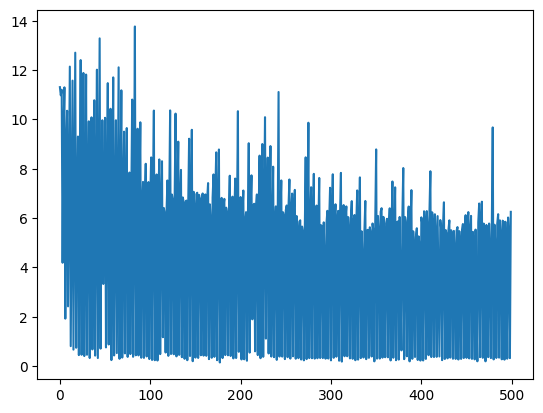

In [128]:
plt.plot(trainer.losses)

In [131]:
window_size = 10
data = torch.tensor(trainer.losses)
moving_avg = torch.conv1d(
    data.view(1, 1, data.size(0)), 
    torch.ones(1, 1, window_size) / window_size, padding=window_size//2
).squeeze()

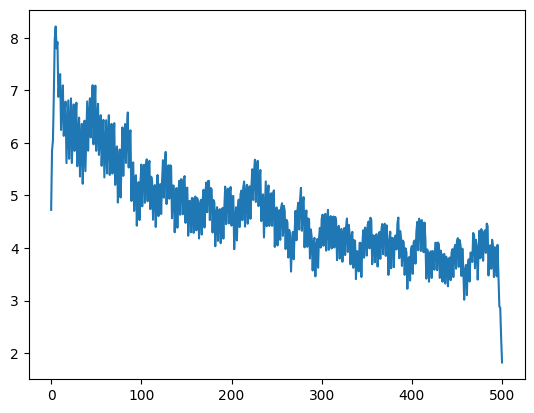

In [132]:
plt.plot(moving_avg)

In [43]:
vqa_batch = next(iter(DataLoader(vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x, num_workers=4)))

In [44]:
emb = vqa_batch[0].embed(model.embedder)
emb.question.embedding.shape, emb.image.embedding.shape, emb.answer.embedding.shape
cc = torch.concat([emb.question.embedding, emb.image.embedding, emb.answer.embedding], dim=1)
F.pad(cc, (0, 0, 0, 1024 - cc.size(1)), value=0).shape

torch.Size([1, 1024, 768])

In [45]:
vqa_batch[0].embed(model.embedder).sequence(1024)[0].shape, vqa_batch[0].embed(model.embedder).sequence(1024)[1].shape

(torch.Size([1024, 768]), torch.Size([1024]))

In [46]:
dl = iter(minigrid_dataloader)

In [56]:
batch = next(dl)

In [57]:
ep = batch
em = [e.embed(model.embedder) for e in ep]
sq = [e.sequence(model.sequence_length) for e in em]
xs, ys, ms = map(torch.stack, zip(*sq))
pr, ys, ms = model(ep)

In [58]:
ep[0].size, ep[0].size // ep[0][0].size, ep[-1].actions.targets, pr.shape, ys.shape

(900,
 6,
 tensor([[   1, 1023],
         [   2, 1023],
         [   2, 1023],
         [   2, 1023],
         [   2, 1023],
         [   2, 1023]]),
 torch.Size([4, 1024, 50257]),
 torch.Size([4, 1024]))

In [59]:
heat = 0.01
prh = pr / heat
sm = prh.softmax(dim=2)

In [60]:
sm.shape

torch.Size([4, 1024, 50257])

Which indexes do you want? Not the 1023, because of padding.

In [61]:
pr.shape, ms.shape, ms[0].nonzero().shape, ms[0].nonzero()

(torch.Size([4, 1024, 50257]),
 torch.Size([4, 1024]),
 torch.Size([12, 1]),
 tensor([[148],
         [149],
         [298],
         [299],
         [448],
         [449],
         [598],
         [599],
         [748],
         [749],
         [898],
         [899]], device='cuda:0'))

In [62]:
[ys[batch_index][ms[batch_index].nonzero().flatten()].to(torch.int) for batch_index in range(len(batch))]

[tensor([   1, 1023,    1, 1023,    2, 1023,    2, 1023,    0, 1023,    2, 1023],
        device='cuda:0', dtype=torch.int32),
 tensor([   2, 1023,    2, 1023,    2, 1023], device='cuda:0',
        dtype=torch.int32),
 tensor([   2, 1023,    0, 1023,    2, 1023,    2, 1023,    2, 1023],
        device='cuda:0', dtype=torch.int32),
 tensor([   1, 1023,    2, 1023,    2, 1023,    2, 1023,    2, 1023,    2, 1023],
        device='cuda:0', dtype=torch.int32)]

In [83]:
[pr[batch_index][ms[batch_index].nonzero().flatten()].argmax(dim=1).to(torch.int) for batch_index in range(len(batch))]

[tensor([   2, 1023,    2, 1023,    2, 1023,    2, 1023,    2, 1023,    2, 1023],
        device='cuda:0', dtype=torch.int32),
 tensor([   2, 1023,    2, 1023,    2, 1023], device='cuda:0',
        dtype=torch.int32),
 tensor([   2, 1023,    2, 1023,    2, 1023,    2, 1023,    2, 1023],
        device='cuda:0', dtype=torch.int32),
 tensor([   2, 1023,    2, 1023,    2, 1023,    2, 1023,    2, 1023,    2, 1023],
        device='cuda:0', dtype=torch.int32)]

In [94]:
ms[0].nonzero().flatten().tolist(), pr[0][0, [1, 2, 1023]]

([148, 149, 298, 299, 448, 449, 598, 599, 748, 749, 898, 899],
 tensor([10.2025, 10.8047,  6.0140], device='cuda:0', grad_fn=<IndexBackward0>))

In [55]:
sl = torch.multinomial(sm[:, 893, :], num_samples=1)
sl

tensor([[1023],
        [1023],
        [1023],
        [1023]], device='cuda:0')

In [101]:
def eval_text():
    model.eval()
    text = "First Citizen:"
    next_word_token = None
    i = 0
    while i < 20 and next_word_token != __text_tokenizer.eos_token:
        with torch.no_grad():
            tokens = text_tokenize(text)
            x = tokens.embed(model.embedder).to(device)
            pr, ys, ms = model([tokens])
            heat = 0.8
            prh = pr / heat
            sm = prh.softmax(dim=2)
            last_index = ms.nonzero()[-1].cpu()[1]
            next_word_probs = sm[0, last_index-1]
            next_word_token = torch.multinomial(next_word_probs, num_samples=1)
            next_word = __text_tokenizer.decode(next_word_token)
            text += next_word
        i += 1
    return text

In [106]:
print(eval_text())

First Citizen:
it are your,
AN,
I be,S, your when people,
 him


In [107]:
targets = [ys[batch_index][ms[batch_index].nonzero().flatten()].to(torch.int) for batch_index in range(len(batch))][0]
predicted = [pr[batch_index][ms[batch_index].nonzero().flatten()].argmax(dim=1).to(torch.int) for batch_index in range(len(batch))][0]
print(f"Control targets:   {targets.tolist()}\nControl predicted: {predicted.tolist()}")

Control targets:   [1, 1023, 1, 1023, 2, 1023, 2, 1023, 0, 1023, 2, 1023]
Control predicted: [2, 1023, 2, 1023, 2, 1023, 2, 1023, 2, 1023, 2, 1023]


In [89]:
sm[0].shape[

torch.Size([1024, 50257])

In [117]:
vqa_sample = next(iter(vqa_dataset["train"]))

In [118]:
vqa_batch = vqa_tokenize(vqa_sample)

In [119]:
vqa_batch

VQATimestep(question=TextTokenData(tokens=tensor([[ 2061,   318,   262, 42658,  2349,   286,   262, 32749,  1444,    30]]), targets=tensor([[ 2061,   318,   262, 42658,  2349,   286,   262, 32749,  1444,    30]]), attention_mask=tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), embedding=tensor([])), image=ImageTokenData(tokens=tensor([[[-0.2027, -0.2171, -0.2428,  ...,  0.2012,  0.2362,  0.2887],
         [-0.1774, -0.1694, -0.1800,  ..., -0.0863, -0.0728, -0.0485],
         [-0.1409, -0.1409, -0.1700,  ...,  0.0578,  0.0631,  0.0739],
         ...,
         [ 0.0972,  0.0924,  0.0732,  ...,  0.2398,  0.2446,  0.2495],
         [ 0.1705,  0.1728,  0.1752,  ...,  0.2814,  0.2162, -0.0036],
         [-0.0532, -0.0909, -0.1568,  ...,  0.2024,  0.1832,  0.1880]]]), targets=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 

In [108]:
question = tokenizer.text_obs("What is the hair style of the blonde called?")
image = tokenizer.image(image_transform(vqa_dataset['train'][0]['image']))
answer_text = "foo"
answer = tokenizer.text_gen(answer_text)
timestep = VQATimestep(question=question, image=image, answer=answer)
timestep.embed(model.embedder)

VQATimestep(question=TextTokenData(tokens=tensor([[ 2061,   318,   262,  4190,  3918,   286,   262, 21541,  1444,    30]]), targets=tensor([[ 2061,   318,   262,  4190,  3918,   286,   262, 21541,  1444,    30]]), attention_mask=tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), embedding=tensor([[[-0.5805, -0.0026, -2.2463,  ...,  0.1824,  0.5532, -0.5343],
         [ 1.5129, -0.6796,  0.2971,  ..., -0.0411,  0.3358,  0.3959],
         [ 0.9331,  1.9109, -0.0039,  ...,  0.5315, -0.7628, -0.4911],
         ...,
         [ 0.2087, -0.2230, -0.0372,  ...,  0.1041,  0.7136,  1.8701],
         [ 0.0037,  0.4166, -1.3697,  ...,  0.3799,  1.1672,  0.9124],
         [-0.0659, -0.4796,  0.5309,  ..., -0.6050, -0.4605, -0.5341]]],
       grad_fn=<EmbeddingBackward0>)), image=ImageTokenData(tokens=tensor([[[-0.1049, -0.1489, -0.1169,  ...,  0.2318,  0.2277,  0.2562],
         [-0.2601, -0.2411, -0.2474,  ...,  0.2021,  0.1989,  0.1925],
         [-0.1489, -0.1873, -0.2092,  ...,  0.2413,  0.2357,  0.2329

In [126]:
model.eval()
question = tokenizer.text_obs("What is the hair style of the blonde called?")
image = tokenizer.image(image_transform(vqa_dataset['train'][0]['image']))
answer_text = __text_tokenizer.bos_token
answer = tokenizer.text_gen(answer_text)
timestep = VQATimestep(question=question, image=image, answer=answer)
next_word_token = None
i = 0
with torch.no_grad():
    pr, ys, ms = model([timestep])
    heat = 0.1
    prh = pr / heat
    sm = prh.softmax(dim=2)
    last_index = ms.nonzero()[-1].cpu()[1]
    next_word_probs = sm[0, last_index-1]
    next_word_token = torch.multinomial(next_word_probs, num_samples=1)
    next_word = __text_tokenizer.decode(next_word_token)
    answer_text += next_word
    answer = tokenizer.text_gen(answer_text, padding=False)
    timestep = VQATimestep(question=question, image=image, answer=answer)

In [127]:
answer_text

'<|endoftext|> park'

In [177]:
xs, ys, ms = timestep.embed(model.embedder).sequence(1024)

In [178]:
xs.shape, ys.shape, ms.shape

(torch.Size([1024, 768]), torch.Size([1024]), torch.Size([1024]))

In [180]:
emb = timestep.embed(model.embedder)
ms.nonzero()

tensor([[154]])

In [182]:
emb.question.embedding.shape, emb.image.embedding.shape

(torch.Size([1, 10, 768]), torch.Size([1, 144, 768]))

In [153]:
def eval_vqa():
    model.eval()
    question = tokenizer.text_obs("What is the hair style of the blonde called?")
    image = tokenizer.image(image_transform(vqa_dataset['train'][0]['image']))
    answer_text = __text_tokenizer.bos_token
    answer = tokenizer.text_gen(answer_text)
    timestep = VQATimestep(question=question, image=image, answer=answer)
    next_word_token = None
    i = 0
    while i < 20 and next_word_token != __text_tokenizer.eos_token:
        with torch.no_grad():
            pr, ys, ms = model([timestep])
            heat = 0.7
            prh = pr / heat
            sm = prh.softmax(dim=2)
            last_index = ms.nonzero()[-1].cpu()[1]
            next_word_probs = sm[0, last_index-1]
            next_word_token = torch.multinomial(next_word_probs, num_samples=1)
            next_word = __text_tokenizer.decode(next_word_token)
            answer_text += next_word
            answer = tokenizer.text_gen(answer_text, padding=False)
            timestep = VQATimestep(question=question, image=image, answer=answer)
        i += 1
    return timestep

In [154]:
result = eval_vqa()

In [155]:
result.answer.tokens[0].shape

torch.Size([20])

In [156]:
__text_tokenizer.decode(result.answer.tokens[0])

'<|endoftext|>agle sign southil signilgeapportotionaglegeWas andgeilalamelBoth'

In [81]:
word.shape

torch.Size([5, 2, 50257])

In [57]:
ms.nonzero()

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4]], device='cuda:0')

In [71]:
ms.nonzero()[-1].cpu()

tensor([0, 4])

In [74]:
tokens.text.tokens[]

tensor(25)

In [56]:
sm.shape, last_index[-1]

(torch.Size([1, 1024, 50257]), tensor([0, 4], device='cuda:0'))

In [ ]:
    tokens = tokenize_text([text], max_length=SEQUENCE_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
    x = embed_text(tokens["input_ids"]).to(device)
    m = tokens["attention_mask"].to(device)
    length = m.sum().item()
    o = model(inputs_embeds=x)
    predicted = lm_head(o.last_hidden_state)
    chosen = torch.multinomial(predicted.softmax(dim=2)[:, length-1], num_samples=1)
    token = chosen[0]
    text += _text_tokenizer.decode(chosen[0])
    i += 1
print(text)

In [ ]:
model.eval()
text = "First Citizen:"
token = None
i = 0
with torch.no_grad():
    while i < 20 and token != _text_tokenizer.eos_token_id:
        tokens = tokenize_text([text], max_length=SEQUENCE_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
        x = embed_text(tokens["input_ids"]).to(device)
        m = tokens["attention_mask"].to(device)
        length = m.sum().item()
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        chosen = torch.multinomial(predicted.softmax(dim=2)[:, length-1], num_samples=1)
        token = chosen[0]
        text += _text_tokenizer.decode(chosen[0])
        i += 1
print(text)

In [183]:
model.eval()

batch = {
    "question": question,
    "image": image,
    "answer": [""],
}
i = 0
token = ""
with torch.no_grad():
    while i < 10 and token != _text_tokenizer.eos_token:
        x, y, m = sequence_vqa(tokenize_text, embed_text, tokenize_image, embed_image, batch)
        x, y, m = x.to(device), y.to(device), m.to(device)
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        token = _text_tokenizer.decode(predicted.softmax(dim=2)[0].multinomial(num_samples=1).squeeze(1)[768+i])
        token = _text_tokenizer.decode(predicted.argmax(dim=2).squeeze(0)[768+i])
        # with temperature
        heat = 0.1
        heated = predicted / heat
        token = _text_tokenizer.decode(heated.softmax(dim=2)[0].multinomial(num_samples=1).squeeze()[768+i])
        batch["answer"][0] += token
        i += 1
batch["answer"]

NameError: name '_text_tokenizer' is not defined